# Analysis of the sister-city network
## Part 1 : Scraping 
We start off by writing a simple scraping algorithm that first yields us all the countries. For the data source we will be following along with the [research paper](https://www.researchgate.net/publication/235356930_Not_All_Paths_Lead_to_Rome_Analysing_the_Network_of_Sister_Cities) and using the wikipedia article which constaints the ["List of towns and sister cities"](https://en.wikipedia.org/wiki/Lists_of_twin_towns_and_sister_cities)

In [2]:
%matplotlib inline 
from bs4 import BeautifulSoup
from urllib.request import urlopen
PARSER = "html.parser"

url = "https://en.wikipedia.org/wiki/Lists_of_twin_towns_and_sister_cities"

html = urlopen(url).read()
soup = BeautifulSoup(html, PARSER)

continents = soup.find_all("span", {"class": "mw-headline"})
continents = [continent.text.replace(" ", "_") for continent in continents]
print(continents)

countries = soup.find_all("a", href=lambda href: href and href.replace("/wiki/List_of_twin_towns_and_sister_cities_in_", "") not in continents and href.startswith("/wiki/List_of_twin_towns_and_sister_cities_in_"))
print(f"num of countries: {len(countries)}")
cleaned_countries = "\n".join([ country.text.replace("List of twin towns and sister cities in ", "") for country in countries ])
print(cleaned_countries)

['Africa', 'Asia', 'Australia_and_Oceania', 'Europe', 'North_America', 'South_America']
num of countries: 161
Cape Verde
Egypt
Kenya
Morocco
South Africa
Tunisia
Armenia
Azerbaijan
Bangladesh
China
Georgia
India
Indonesia
Iran
Iraq
Israel
Japan
Jordan
Kazakhstan
Malaysia
Pakistan
Palestine
Russia
South Korea
Taiwan
Oceania
Australia
Fiji
New Zealand
Albania
Austria
Belarus
Belgium
Bosnia and Herzegovina
Bulgaria
Croatia
the Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Iceland
the Republic of Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Moldova
Montenegro
the Netherlands
North Macedonia
Norway
Poland
Portugal
Romania
Russia
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
Turkey
Ukraine
the United Kingdom
England
Scotland
Wales
Canada
Cuba
Mexico
Nicaragua
Argentina
Brazil
Chile
Cape Verde
Egypt
Kenya
Morocco
South Africa
Tunisia
Armenia
Artsakh
Azerbaijan
Bangladesh
China
Georgia
India
Indonesia
Iran
Iraq
Israel
Japan
Jordan
Malaysia
Northern Cyprus
Pakistan

Once we have all the countries we simply apply the same idea to get all the cities and respective sister cities. We can then easily generate the graph after cleaning the html. For the sake of simplicity starting off I decided to limit the order of the graph to 100, that is I restricted the number of city nodes to 100.

In [29]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import bs4
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pprint
import csv

SOURCE_LINK = "https://en.m.wikipedia.org"
PARSER = "html.parser"

G = nx.Graph()

sister_cities_dict = dict()

def yield_soup(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, PARSER)
    return soup

def give_next_next(city) -> bs4.element.Tag:
    next = city.parent.find_next_sibling()
    if next:
        next = next.find_next_sibling()
    
    return next or city
    
def give_next(city) -> bs4.element.Tag:
    next = city.parent.find_next_sibling()
    return next or city

def tag_check(city, sister_cities):
    if give_next_next(city.parent).name == "div":
        sister_cities.append(give_next_next(city.parent));
        return True;
    if give_next(city.parent).name == "ul":
        sister_cities.append(give_next(city.parent));
        return True;
    return False;

def generate_edges(country_url):
    """
    Generate edges for the graph between city and all its sister cities
    """
    country_soup = yield_soup(country_url)

    cities = country_soup.find_all("b")

    sister_cities = []

    cities = map(
        lambda city: "".join(
            [
                city.text
                for city in city.find_all("a")
                if(tag_check(city, sister_cities))
            ]
        ),
        cities
    )
    cities = list(
        filter(lambda city: city != "" and city != "" and city != "^", cities)
    )

    # find all corresponding sister cities
    sister_city_list = list(
        map(
            lambda sister_city: [
                [
                    word.lstrip().rstrip()
                    for word in re.sub(
                        r"\[\d+\]",
                        "",
                        (sister_city.parent.text)  # remove citation
                        .replace("\xa0", "")  # remove non-breaking space
                    ).split(",")
                ]
                for sister_city in sister_city.find_all(
                    "a", href=lambda href: href and not href.startswith("#cite_note")
                )
                if sister_city.parent.name != "span"
            ],
            sister_cities,
        )
    )

    adj_list_dict = dict(zip(cities, sister_city_list))
    # append this to the global dict
    sister_cities_dict.update(adj_list_dict)
    pprint.pprint(adj_list_dict)

    for k, v in adj_list_dict.items():
        for city in v:
            G.add_edge(k, city[0])

for country in countries:
    country_url = SOURCE_LINK + country["href"]
    if len(G) < 10:
        generate_edges(country_url)

# writing the final data
with open("assets/adj_list.csv", "w") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in sister_cities_dict.items():
        writer.writerow([key, value])

{'Boa Vista': [['Aljezur', 'Portugal'],
               ['Anadia', 'Portugal'],
               ['Cabeceiras de Basto', 'Portugal'],
               ['Felgueiras', 'Portugal'],
               ['Loulé', 'Portugal'],
               ['Seixal', 'Portugal'],
               ['Zocca', 'Italy']],
 'Brava': [['Cartaxo', 'Portugal'], ['Santarém', 'Portugal']],
 'Maio': [['Arraiolos', 'Portugal'],
          ['Loures', 'Portugal'],
          ['São João da Madeira', 'Portugal'],
          ['Vila Nova de Poiares', 'Portugal']],
 'Mosteiros': [['Amadora', 'Portugal'],
               ['Ansião', 'Portugal'],
               ['Azambuja', 'Portugal'],
               ['Entroncamento', 'Portugal']],
 'Paul': [['Ribeira Grande', 'Portugal']],
 'Porto Novo': [['Angra do Heroísmo', 'Portugal'],
                ['Madalena', 'Portugal'],
                ['Ribeira Grande', 'Portugal'],
                ['Tavira', 'Portugal']],
 'Praia': [['Boston', 'United States'],
           ['Faro', 'Portugal'],
           ['Figue

AttributeError: 'NoneType' object has no attribute 'find_next_sibling'

## Part 2 : Displaying 
Now if we just use the basic layout for drawing networks then there is alot of overlap with the nodes which makes everything quite unreadable.

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True)
plt.show()

So the first observation should be that the nodes are too close together. Also the text overflows the nodes quite heavily. Furhtermore the different components of the graph are scattered quite sporadically. So to fix this we can address each issue step by step. 

**issue 1 - Nodes too close**

To solve the nodes being to close we can use the spring layout. Which quoting the documentation : 
```
... simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force
```

The important parameter here is `k` which as it increases moves nodes further apart from oneanother. I could not figure out any nice way to find a nice value besides brute force so after a little bit of testing I settled on $20\times \displaystyle\frac{1}{\sqrt{\text{number of nodes}}}$

**issue 2 - Node sizes** 

Clearly we want the nodes to cover a larger portion of the word to make it look less awkward, to do this we can simply increase the `node_size` argument and maybe also change the color of the nodes and edges to something more pastel to give the graph a less harsh appearance.

In [ ]:
# controls the graph layout
pos = nx.spring_layout(G, 
                       k=20*1/np.sqrt(len(G.nodes())), 
                       iterations=400,
                       scale=1000)

plt.figure(figsize=(20, 20))

# draw nodes and edges
nx.draw(G, pos=pos, 
        node_size=1000, 
        node_color='lightblue', 
        edge_color='gray', 
        alpha=0.7, 
        width=0.5)

nx.draw_networkx_labels(G, pos=pos, font_size=8)
plt.axis('off')
plt.savefig("assets/graph.svg", transparent=True)
plt.show()

### 2.1 improving the display using pyvis
One of the most prominant issues which is still apparent is that nodes still overlap to the point where it makes certain labels illegible. Here we could play around a bit more networkx but pyviz, which can interface with networkx, might be better suited moving forwards.

In [ ]:
from pyvis.network import Network

net = Network(notebook=True, height="1000px", width="1000px", bgcolor="#222222", font_color="white", cdn_resources='remote')
net.from_nx(G)
net.show("assets/basic_example.html")

This is alot nicer, now lets see scrape a few more cities and then see what our graph looks like. To improve the performance we can disable dragging of the nodes using the `toggle_drag_nodes(false)` 

In [ ]:
for country in countries:
    country_url = "http://en.sistercity.info" + country["href"]
    if len(G) < 500:
        generate_edges(country_url)

In [ ]:
net = Network(notebook=True, height="1000px", width="1000px", bgcolor="#222222", font_color="white")
net.from_nx(G)
net.show("assets/more_cities.html")

### 2.2 Final refinements 
One final change I think would improve the visualization would be to make the degree centrality of a node correspond to its size. This is a simple addition to our display code.

In [ ]:
net = Network(notebook=True, height="1000px", width="100%", bgcolor="#222222", font_color="white")
net.from_nx(G)
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
net.toggle_drag_nodes(False)
net.show("assets/all_cities.html")

## Part 3: Analysis
One of the first things I thought would be cool to see would be the network of the sister cities visualized ontop of the worldmap. Similar to the following [image](https://www.researchgate.net/figure/Connections-between-sister-cities-visualised-on-a-world-map-Shorter-connections-are_fig2_235356930) but at a higher resolution.
Breaking this problem down : 
1. I need to get some high resolution image of the world map, something which would hopefully not degrade too much in quality with zooming.
2. I would somehow need to correspond each node representing a city with its coordinate on the world map. 
3. Once I have that I should in theory just be able to render the graph based off the edges I already have stored.

### 3.1 Rendering the image
So the first thing that comes to mind with "high resolution that doesnt degrade in quality with scaling" is obviously svg, so now the challanges becomes how do we actually display the svg then how do we have the network overlay the svg. 
Matplotlib can apparently display images and also interface with networkx so lets give that a go.

In [ ]:
import svgutils.compose as sc
from IPython.display import SVG

svg_path = "assets/world.svg"
fig, ax = plt.subplots(figsize=(4, 4))

fig.savefig("assets/cover.svg", transparent=True)
plt.close(fig)

# Here starts the assembling using svgutils
sc.Figure("20cm", "10cm",
          sc.SVG("assets/world.svg").scale(0.01),
          sc.SVG("assets/graph.svg").scale(0.0025).move(1, 1),
).save("assets/compose.svg")

SVG("assets/compose.svg")

Well, now that worked, doesn't really mean much as it stands but its a nice proof of concept. Clearly the idea works. So onto step 2.

### 3.2 Mapping the city nodes to coordinates
This might be a bit harder. So in practice what this means is that for each node we need some $(x, y)$ coordinate corresponding to its real world coordinates. That is, we need to translate all real world coordinates to the 2D coordinate plane and then scale it all to some desired value. Lets start off by getting a dataset of cities with associated lat/long values.

In [ ]:
import pandas as pd
df = pd.read_csv('assets/worldcities.csv')
for index, row in df.iterrows():
    print(row['city'], row['lat'], row['lng'])

Now that we have that lets see if we can convert the lat and long to a pair of $(x, y)$ coordinates. For this we can use the **Universal Trasverse Mercator Projection**. Which is specifically meant for the purposes of assigning coordinates to locations on the surface of earth. The nice thing is we can use the `utm` python package which handles this conversion for us. After which all we need to do is scale the resulting coordinates to our desired range. Then from this information we can place the nodes on their geographically correct poisitons.

In [ ]:
import utm 
xmax = 100000
ymax = 100000
coords = []
for index, row in df.iterrows():
    lat = row['lat']
    lon = row['lng']

    # convert lat and lon to utm
    x, y, zone, letter = utm.from_latlon(lat, lon)

    # scaling x and y down
    # x = x / xmax 
    # y = y / ymax
    coords.append((row['city'], x, y))

print(coords[0:10])

G2 = nx.Graph()

for(coord) in coords[0:10]:
    print(coord[0], coord[1], coord[2])
    G2.add_node(coord[0], pos=(coord[1], coord[2]))

plt.figure(figsize=(15, 15))

# draw nodes and edges
nx.draw(G2, pos=nx.get_node_attributes(G2,'pos'), 
        node_size=1000, 
        node_color='lightblue', 
        edge_color='gray', 
        alpha=0.7, 
        width=0.5)

nx.draw_networkx_labels(G2, pos=nx.get_node_attributes(G2,'pos'), font_size=8)
plt.axis('off')
plt.show()

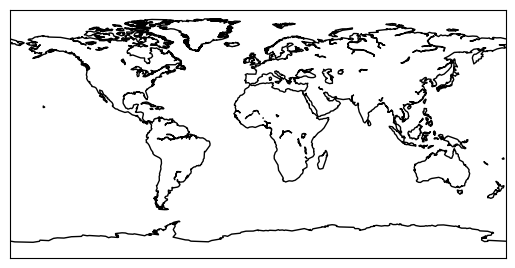

<Figure size 640x480 with 0 Axes>

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap()

map.drawcoastlines()

plt.show()
plt.savefig('test.png')